<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_043_class_1_recall_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from loan_data_utils import load_and_preprocess_data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Assuming the `load_and_preprocess_data` function is defined elsewhere
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])


### Load Optimal Parameters and Train Models

In [11]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN, SMOTE
import json

# Load the top models and parameters by category
with open('/content/top_models_by_category.json', 'r') as f:
    top_models_by_category = json.load(f)

# Extract the best parameters
best_params_lr_adasyn = top_models_by_category["Class 1 Recall"]["Logistic Regression (ADASYN)"]["best_params"]
best_params_lr_smote = top_models_by_category["Class 1 Recall"]["Logistic Regression (SMOTE)"]["best_params"]
best_params_lgbm = top_models_by_category["Class 1 Recall"]["LGBM (SMOTE)"]["best_params"]

# Define pipelines with the best parameters
pipeline_lr_adasyn_best = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', ADASYN()),
    ('classifier', LogisticRegression(random_state=42, **best_params_lr_adasyn))
])

pipeline_lr_smote_best = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', SMOTE()),
    ('classifier', LogisticRegression(random_state=42, **best_params_lr_smote))
])

pipeline_lgbm_best = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', SMOTE()),
    ('classifier', LGBMClassifier(random_state=42, **best_params_lgbm))
])

# Fit the models
pipeline_lr_adasyn_best.fit(X_train, y_train)
pipeline_lr_smote_best.fit(X_train, y_train)
pipeline_lgbm_best.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6539
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age', 'pay_1',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'education',
                                                   'marriage'])])),
                ('resampler', SMOTE()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.2, n_estimators=300,
                                random_state=42))])

### Optimized for Balanced F1 Scores

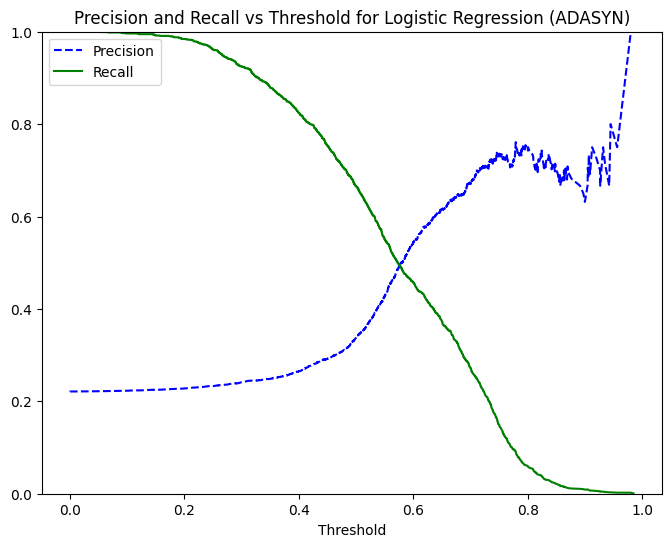

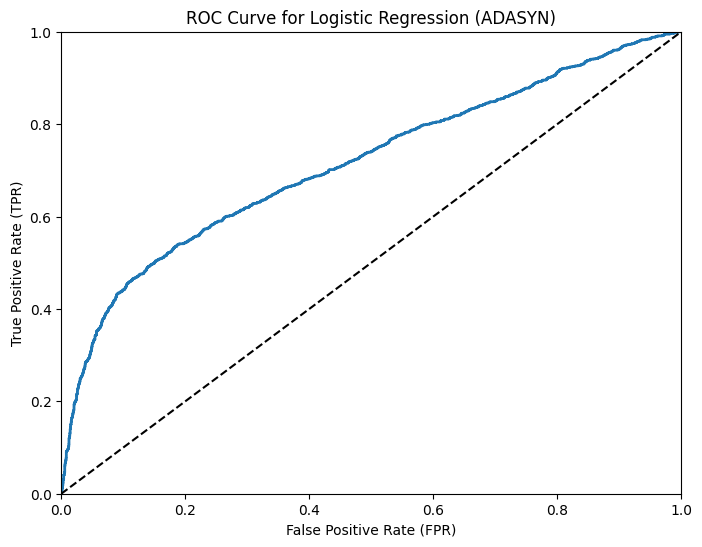

Best Threshold for Logistic Regression (ADASYN): 0.6000185935781098
Best F1 Score for Logistic Regression (ADASYN): 0.49754500818330605


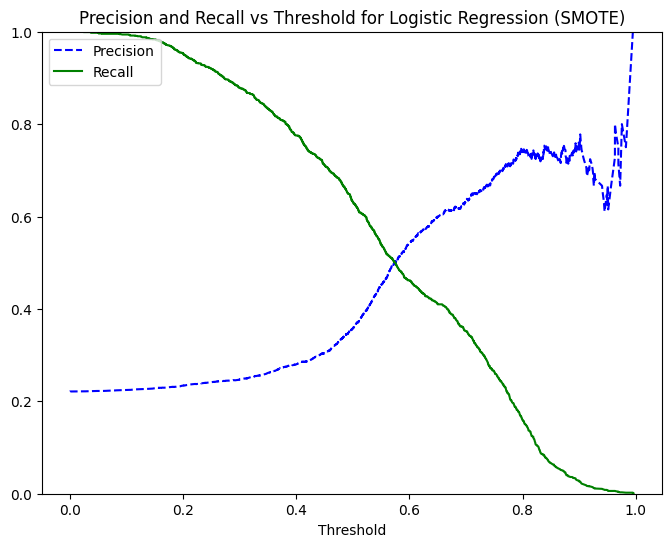

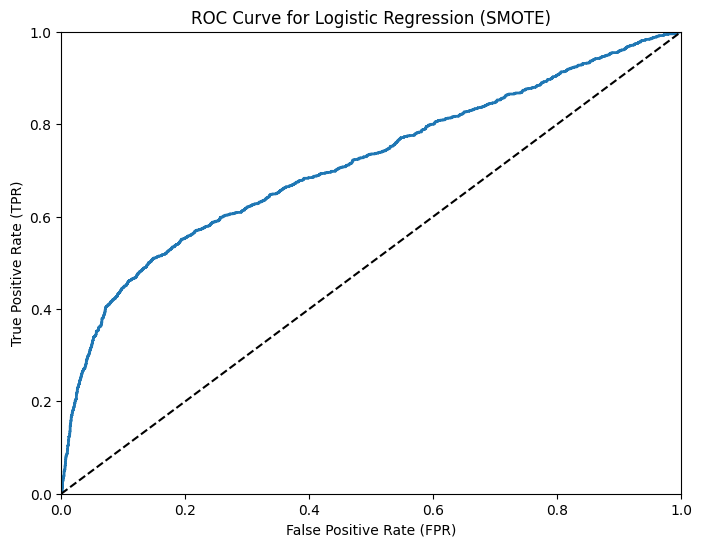

Best Threshold for Logistic Regression (SMOTE): 0.5697793703420708
Best F1 Score for Logistic Regression (SMOTE): 0.5018559762435041


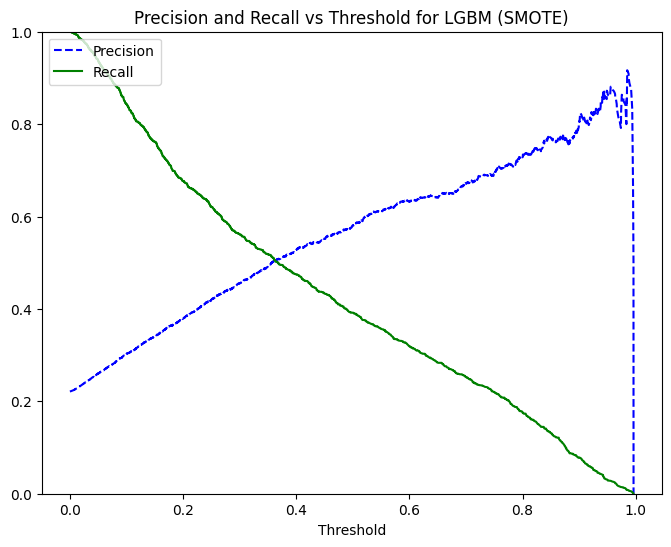

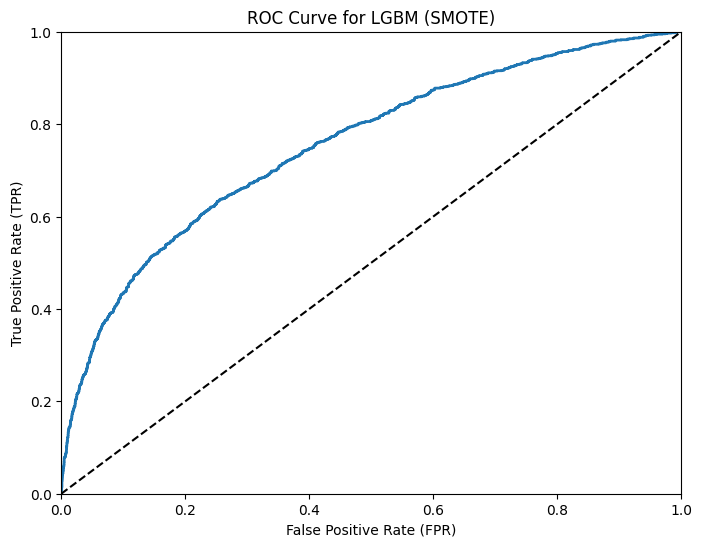

<ipython-input-15-6f2f730412ec>:34: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


Best Threshold for LGBM (SMOTE): 0.9960293766363604
Best F1 Score for LGBM (SMOTE): nan
Logistic Regression (ADASYN) with Optimized Threshold
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.54      0.46      0.50      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.67      0.68      6000
weighted avg       0.78      0.80      0.79      6000

Logistic Regression (SMOTE) with Optimized Threshold
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4673
           1       0.49      0.51      0.50      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.78      0.78      0.78      6000

LGBM (SMOTE) with Optimized Threshold
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
    

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.title(f"Precision and Recall vs Threshold for {model_name}")
    plt.show()

def plot_roc_curve(fpr, tpr, thresholds, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model_name}')
    plt.show()

# Function to optimize threshold for a given model
def optimize_threshold(model, X_test, y_test, model_name):
    y_scores = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)

    # Plot precision-recall vs threshold
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model_name)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, roc_thresholds, model_name)

    # Find the best threshold for maximum F1 score
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1_score = f1_scores[best_threshold_index]

    print(f'Best Threshold for {model_name}: {best_threshold}')
    print(f'Best F1 Score for {model_name}: {best_f1_score}')

    return best_threshold

# Optimize thresholds for the models
best_threshold_lr_adasyn = optimize_threshold(pipeline_lr_adasyn_best, X_test, y_test, 'Logistic Regression (ADASYN)')
best_threshold_lr_smote = optimize_threshold(pipeline_lr_smote_best, X_test, y_test, 'Logistic Regression (SMOTE)')
best_threshold_lgbm = optimize_threshold(pipeline_lgbm_best, X_test, y_test, 'LGBM (SMOTE)')

# Apply the best threshold to make predictions
def predict_with_threshold(model, X, threshold):
    y_scores = model.predict_proba(X)[:, 1]
    return (y_scores >= threshold).astype(int)

# Predict with the optimized thresholds
y_pred_lr_adasyn = predict_with_threshold(pipeline_lr_adasyn_best, X_test, best_threshold_lr_adasyn)
y_pred_lr_smote = predict_with_threshold(pipeline_lr_smote_best, X_test, best_threshold_lr_smote)
y_pred_lgbm = predict_with_threshold(pipeline_lgbm_best, X_test, best_threshold_lgbm)

# Evaluate the models with the optimized thresholds
print("Logistic Regression (ADASYN) with Optimized Threshold")
print(classification_report(y_test, y_pred_lr_adasyn))

print("Logistic Regression (SMOTE) with Optimized Threshold")
print(classification_report(y_test, y_pred_lr_smote))

print("LGBM (SMOTE) with Optimized Threshold")
print(classification_report(y_test, y_pred_lgbm))


### Optimized for Recall

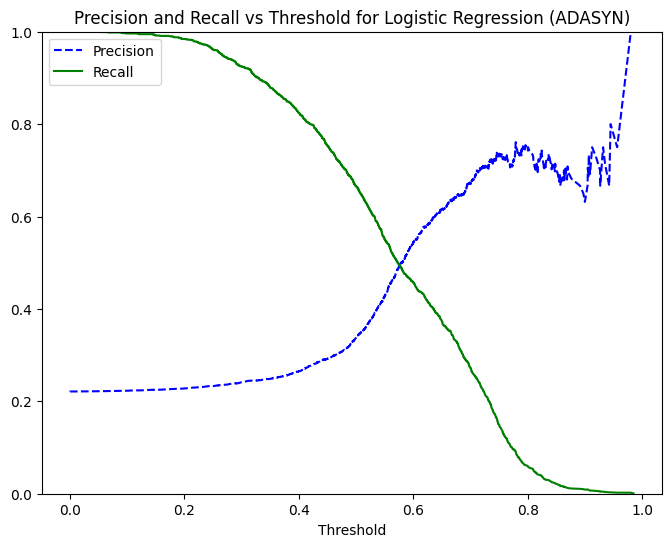

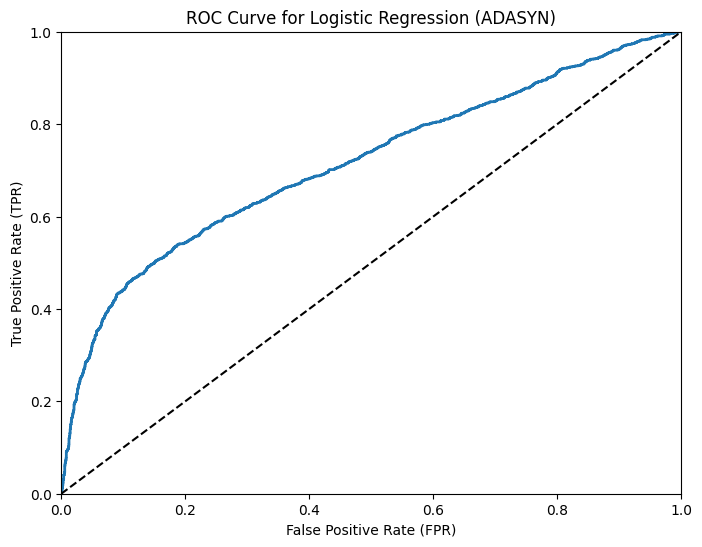

Best Threshold for Logistic Regression (ADASYN): 6.041815457258132e-08
Best Recall for Logistic Regression (ADASYN): 1.0


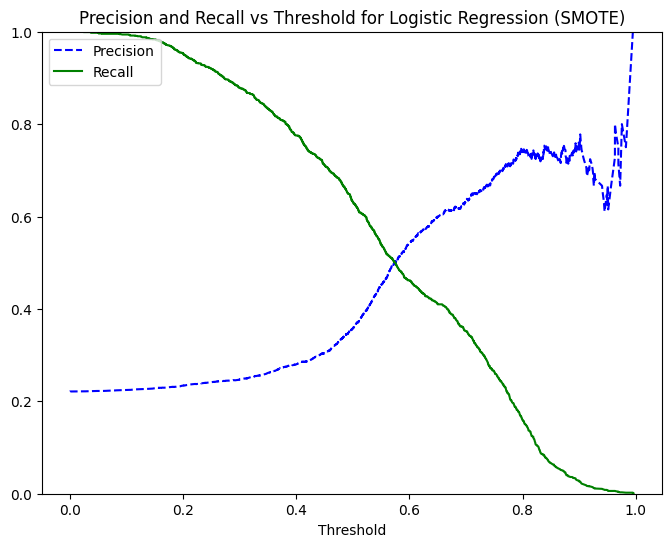

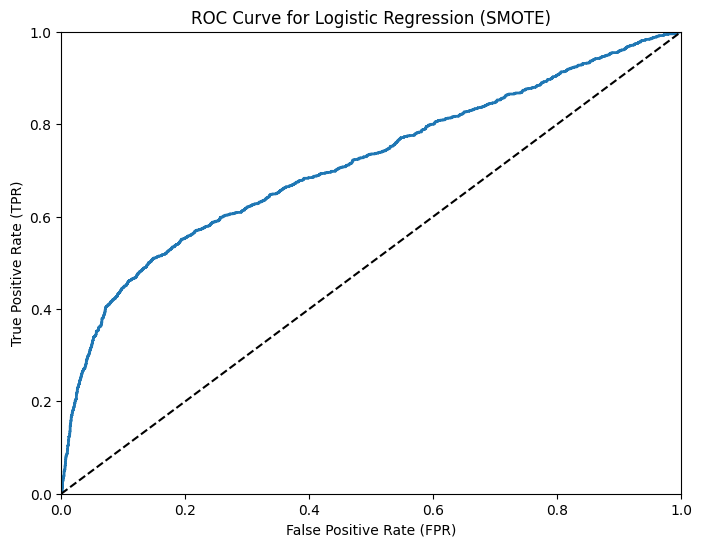

Best Threshold for Logistic Regression (SMOTE): 5.380299542180955e-10
Best Recall for Logistic Regression (SMOTE): 1.0


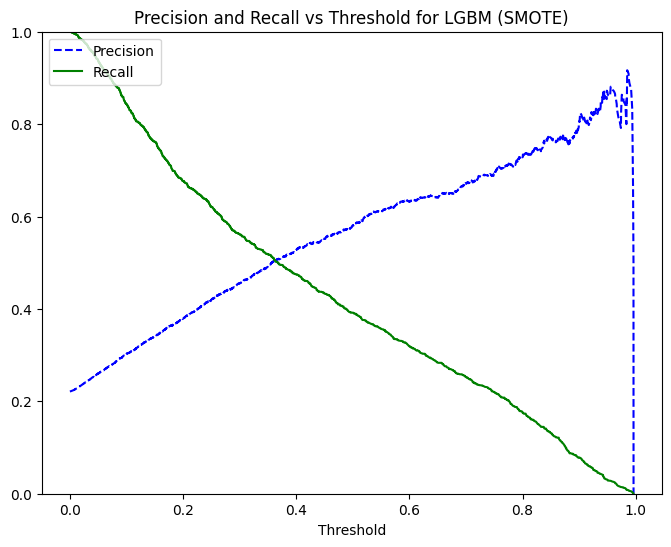

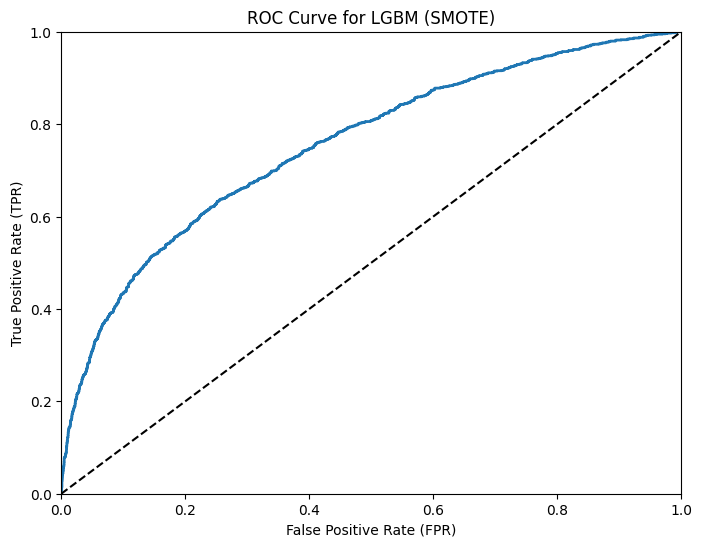

Best Threshold for LGBM (SMOTE): 9.30932285228953e-05
Best Recall for LGBM (SMOTE): 1.0
Logistic Regression (ADASYN) with Optimized Threshold
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4673
           1       0.22      1.00      0.36      1327

    accuracy                           0.22      6000
   macro avg       0.11      0.50      0.18      6000
weighted avg       0.05      0.22      0.08      6000

Logistic Regression (SMOTE) with Optimized Threshold
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4673
           1       0.22      1.00      0.36      1327

    accuracy                           0.22      6000
   macro avg       0.11      0.50      0.18      6000
weighted avg       0.05      0.22      0.08      6000

LGBM (SMOTE) with Optimized Threshold
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4673
    

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.title(f"Precision and Recall vs Threshold for {model_name}")
    plt.show()

def plot_roc_curve(fpr, tpr, thresholds, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model_name}')
    plt.show()

# Function to optimize threshold for high recall
def optimize_threshold_for_recall(model, X_test, y_test, model_name):
    y_scores = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)

    # Plot precision-recall vs threshold
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model_name)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, roc_thresholds, model_name)

    # Find the best threshold for maximum recall
    best_threshold_index = np.argmax(recalls)
    best_threshold = thresholds[best_threshold_index]
    best_recall = recalls[best_threshold_index]

    print(f'Best Threshold for {model_name}: {best_threshold}')
    print(f'Best Recall for {model_name}: {best_recall}')

    return best_threshold

# Optimize thresholds for the models
best_threshold_lr_adasyn = optimize_threshold_for_recall(pipeline_lr_adasyn_best, X_test, y_test, 'Logistic Regression (ADASYN)')
best_threshold_lr_smote = optimize_threshold_for_recall(pipeline_lr_smote_best, X_test, y_test, 'Logistic Regression (SMOTE)')
best_threshold_lgbm = optimize_threshold_for_recall(pipeline_lgbm_best, X_test, y_test, 'LGBM (SMOTE)')

# Apply the best threshold to make predictions
def predict_with_threshold(model, X, threshold):
    y_scores = model.predict_proba(X)[:, 1]
    return (y_scores >= threshold).astype(int)

# Predict with the optimized thresholds
y_pred_lr_adasyn = predict_with_threshold(pipeline_lr_adasyn_best, X_test, best_threshold_lr_adasyn)
y_pred_lr_smote = predict_with_threshold(pipeline_lr_smote_best, X_test, best_threshold_lr_smote)
y_pred_lgbm = predict_with_threshold(pipeline_lgbm_best, X_test, best_threshold_lgbm)

# Evaluate the models with the optimized thresholds
print("Logistic Regression (ADASYN) with Optimized Threshold")
print(classification_report(y_test, y_pred_lr_adasyn, zero_division=0))

print("Logistic Regression (SMOTE) with Optimized Threshold")
print(classification_report(y_test, y_pred_lr_smote, zero_division=0))

print("LGBM (SMOTE) with Optimized Threshold")
print(classification_report(y_test, y_pred_lgbm, zero_division=0))


In [20]:
# Apply the specified thresholds to make predictions
def predict_with_threshold(model, X, threshold):
    y_scores = model.predict_proba(X)[:, 1]
    return (y_scores >= threshold).astype(int)

# Predict with the specified thresholds
thresholds = [0.2, 0.2, 0.1]
y_pred_lr_adasyn = predict_with_threshold(pipeline_lr_adasyn_best, X_test, thresholds[0])
y_pred_lr_smote = predict_with_threshold(pipeline_lr_smote_best, X_test, thresholds[1])
y_pred_lgbm = predict_with_threshold(pipeline_lgbm_best, X_test, thresholds[2])

# Evaluate the models with the specified thresholds
print("Logistic Regression (ADASYN) with Specified Threshold")
print(classification_report(y_test, y_pred_lr_adasyn, zero_division=0))

print("Logistic Regression (SMOTE) with Specified Threshold")
print(classification_report(y_test, y_pred_lr_smote, zero_division=0))

print("LGBM (SMOTE) with Specified Threshold")
print(classification_report(y_test, y_pred_lgbm, zero_division=0))

# Update the top models and parameters with the specified thresholds
top_model_params = {
    "Class 1 Recall": {
        "Logistic Regression (ADASYN)": {
            "best_params": best_params_lr_adasyn,
            "threshold": thresholds[0]
        },
        "Logistic Regression (SMOTE)": {
            "best_params": best_params_lr_smote,
            "threshold": thresholds[1]
        },
        "LGBM (SMOTE)": {
            "best_params": best_params_lgbm,
            "threshold": thresholds[2]
        }
    }
}

# Save the updated top model parameters to a new JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)

# Load the saved parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Loop through the parameters and print them
for category, models in top_model_params.items():
    print(f"Category: {category}")
    for model_name, params in models.items():
        print(f"  Model: {model_name}")
        print(f"    Best Params: {params['best_params']}")
        print(f"    Threshold: {params['threshold']}")


Logistic Regression (ADASYN) with Specified Threshold
              precision    recall  f1-score   support

           0       0.92      0.05      0.10      4673
           1       0.23      0.98      0.37      1327

    accuracy                           0.26      6000
   macro avg       0.57      0.52      0.24      6000
weighted avg       0.77      0.26      0.16      6000

Logistic Regression (SMOTE) with Specified Threshold
              precision    recall  f1-score   support

           0       0.90      0.11      0.20      4673
           1       0.23      0.95      0.38      1327

    accuracy                           0.30      6000
   macro avg       0.57      0.53      0.29      6000
weighted avg       0.75      0.30      0.24      6000

LGBM (SMOTE) with Specified Threshold
              precision    recall  f1-score   support

           0       0.91      0.45      0.60      4673
           1       0.30      0.84      0.45      1327

    accuracy                         